In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import models,layers
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utils import cyclical_encoder
from utils import train_val_test_split
from utils import get_model_metrics

import datetime

# Load Feature Channels
['temp', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'tsun']  ["Wind","Solar"]

In [2]:
def min_max_normalize_target_var(df):
    # fix the min and max according to phisical properties:
    X_max = 100_000
    
    for col in df.columns:
        df[col] /= X_max
        
    return df

In [3]:
def train_val_test_split_np(feature_matrix, val_days, test_days):


    print('The shape of the feature data set is: {}'.format(feature_matrix.shape))
#     print('The shape of the target data set is: {}'.format(target_matrix.shape))

    rows_for_test = test_days*96
    rows_for_val = val_days*96

    X_train = feature_matrix[:-(rows_for_test + rows_for_val)]
#     y_train = target_matrix[105_120:-(rows_for_test + rows_for_val)]
    print('--------------------------------------------')
    print('The shape of the train set is: {}'.format(X_train.shape))
#     print('The shape of the target variable is: {}'.format(y_train.shape))
    print('--------------------------------------------')

    X_val = feature_matrix[X_train.shape[0]:-(rows_for_test)]
#     y_val = target_matrix[y_train.shape[0]+105_120:-(rows_for_test)]
    print('\n--------------------------------------------')
    print('The shape of the validation set is: {}'.format(X_val.shape))
#     print('The shape of the target variable for the validation set is: {}'.format(y_val.shape))
    print('--------------------------------------------')

    X_test = feature_matrix[X_val.shape[0]+X_train.shape[0]:]
#     y_test = target_matrix[y_val.shape[0]+X_train.shape[0]+105_120:]
    print('\n--------------------------------------------')
    print('The shape of the test set is: {}'.format(X_test.shape))
#     print('The shape of the target variable for the test set is: {}'.format(y_test.shape))
    print('--------------------------------------------\n')

    return X_train, X_val, X_test

In [4]:
def get_model_metrics(y_true_with_date, y_prediction):

    y_true = np.array(y_true_with_date.iloc[:,1])
    y_pred = np.array(y_prediction)

    # get the total error and the overall MAE

    overall_mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true,y_pred)
    absolute_error = overall_mae * len(y_true)

    print('----------------------------------------------')
    print(f'The absolute error (total actual minus  forecast) in MW is: {round(absolute_error, 2)}')
    print(f'The overall mean absolute error of the model in MW is: {overall_mae}')
    print(f'The overall mean squared error of the model is: {mse}')
#     print('----------------------------------------------')

    # get the overall mean absolute scaled error (MASE)

    naive_forecast = y_true[1:]
    y_true_for_mase = y_true[:-1]
    mae_naive = mean_absolute_error(y_true_for_mase, naive_forecast)
    overall_mae_without_first_observation = mean_absolute_error(y_true[1:], y_pred[1:])

    overall_mase = overall_mae_without_first_observation/mae_naive

#     print('----------------------------------------------')
    print(f'The overall mean absolute scaled error of the model in MW is: {overall_mase}')
    print('----------------------------------------------')

    # get the MAE for every day and return a dataframe and charts

    time_stamp = np.array(
                 pd.to_datetime(y_true_with_date.iloc[:,0], format='%Y-%m-%d %H:%M:%S').dt.date
                 )

    date_list = list()
    y_true_list = list()
    y_pred_list = list()

    df = pd.DataFrame({'Date': time_stamp,
                       'y_true': y_true,
                       'y_pred': y_pred})

    list_of_days = sorted(list(set(df.Date.values)))

    for day in list_of_days:
        sub_df = df.query('Date == @day')
        date_list.append(sub_df.Date.values)
        y_true_list.append(sub_df.y_true.values)
        y_pred_list.append(sub_df.y_pred.values)

    mae_list = list()
    for i, j, k in zip(y_true_list, y_pred_list, date_list):
        MAE = mean_absolute_error(i, j)
        mae_list.append(MAE)

    del df

    df = pd.DataFrame({'day':list_of_days, 'MAE': mae_list},)
#     print('----------------------------------------------\n')

    return df

In [5]:
file = 'Feature_channels/feature_channel_16x10.npy'
feature_channel = np.load(file, allow_pickle=False)

In [6]:
feature_channel = np.moveaxis(feature_channel, -1, 0)
feature_channel = np.nan_to_num(feature_channel, nan=-.01)

In [7]:
# ['temp', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'tsun'] ["Wind","Solar"]
#    0       1        2       3      4        5      6        7      8

In [8]:
# feature_channel = feature_channel[105_120:204004,:,:,[0,4,7,8]]
# # feature_channel[:204004,:,:,[0,4,7,8]].shape
# feature_channel.shape

In [9]:
# feature_channel = feature_channel[105_120:204004,:,:,:]  # to adjust for the difference in datasets
feature_channel = feature_channel[:204004,:,:,:]

In [10]:
X_train_fc, X_val_fc,X_test_fc= train_val_test_split_np(feature_channel, 90, 90)

The shape of the feature data set is: (204004, 16, 10, 9)
--------------------------------------------
The shape of the train set is: (186724, 16, 10, 9)
--------------------------------------------

--------------------------------------------
The shape of the validation set is: (8640, 16, 10, 9)
--------------------------------------------

--------------------------------------------
The shape of the test set is: (8640, 16, 10, 9)
--------------------------------------------



# Load Entso-e Data

In [11]:
df = pd.read_csv("small_dataset.csv",parse_dates=[0])

In [12]:
# df = df.iloc[105_120:,:]

In [13]:
df = cyclical_encoder(df,1440,"minute")
df = cyclical_encoder(df,12,"month")
df = cyclical_encoder(df,7,"weekday")
df["Year"] = df["Date"].dt.year-2014

In [14]:
target_vars = ["System total load in MAW","Wind Offshore in MAW","Wind Onshore in MAW","Solar in MAW"]
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(df, target_vars, 90, 90)

The shape of the data set is: (204004, 12)

--------------------------------------------
The shape of the train set is: (186724, 7)
The shape of the target variable is: (186724, 4)
--------------------------------------------

--------------------------------------------
The shape of the validation set is: (8640, 7)
The shape of the target variable for the validation set is: (8640, 4)
--------------------------------------------

--------------------------------------------
The shape of the test set is: (8640, 7)
The shape of the target variable for the test set is: (8640, 5)
--------------------------------------------


In [15]:
X_train = pd.concat([X_train,y_train],axis=1)
X_val = pd.concat([X_val,y_val],axis=1)
X_test = pd.concat([X_test,y_test.drop(columns=["Date"])],axis=1)
cols = [x for x in X_train.columns if x not in "sin_minute sin_minute \
        cos_minute sin_month cos_month sin_weekday cos_weekday Year"]

In [16]:
scaler_f = StandardScaler()
X_train.loc[:,cols] = scaler_f.fit_transform(X_train.loc[:,cols])
X_val.loc[:,cols] = scaler_f.transform(X_val.loc[:,cols])
X_test.loc[:,cols] = scaler_f.transform(X_test.loc[:,cols])

scaler_t = StandardScaler()
y_train = scaler_t.fit_transform(y_train)
y_val = scaler_t.transform(y_val)
y_test.loc[:,target_vars] = scaler_t.transform(y_test.loc[:,target_vars])

In [17]:
def split_sequences(features,target, n_steps):
    X, y = list(), list()
    for i in range(len(target)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix+1 > len(target):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = features.iloc[i:end_ix, :], target.iloc[end_ix,:]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [18]:
n_steps = 4
seq_X_train,seq_y_train = split_sequences(X_train,pd.DataFrame(y_train), n_steps)
seq_X_val,seq_y_val = split_sequences(X_val,pd.DataFrame(y_val), n_steps)

n_features = seq_X_train.shape[2]

In [19]:
qry = seq_X_train.astype('float32')
key = seq_X_train.astype('float32') 
values = seq_X_train.astype('float32')
fc_in = X_train_fc[n_steps:,:,:,:]
fc_in_val = X_val_fc[n_steps:,:,:,:]

In [20]:
seq_X_train.shape,  X_train_fc[n_steps:,:,:,:].shape

((186720, 4, 11), (186720, 16, 10, 9))

# Model

In [21]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [22]:
def attention_head(q_in,k_in, v_in, capacity):
    Q = Dense(capacity, activation='linear')(q_in)
    K = Dense(capacity, activation='linear')(k_in)
    V = Dense(capacity, activation='linear')(v_in)
    query_value_attention  = tf.keras.layers.Attention()([Q,V,K])
#     return query_value_attention
    return tf.reduce_sum(query_value_attention, 1)   

In [23]:
q_in = Input(shape=(n_steps, n_features))
k_in = Input(shape=(n_steps, n_features))
v_in = Input(shape=(n_steps, n_features))

d_model = n_features
position = n_steps
pos_q = tf.math.add(q_in,positional_encoding(position,d_model))
pos_k = tf.math.add(k_in,positional_encoding(position,d_model))
pos_v = tf.math.add(v_in,positional_encoding(position,d_model))
  

capacity = n_features
# head_1 = attention_head(q_in,k_in, v_in, capacity)
# head_2 = attention_head(q_in,k_in, v_in, capacity)
n_heads = 6
list_heads = []
for i in range(n_heads):
    list_heads.append(attention_head(pos_q,pos_k, pos_v, capacity))

input_into_NN = tf.keras.layers.Concatenate()(list_heads)
flatten_attn = tf.keras.layers.Flatten()(input_into_NN)

In [24]:
input_shape=feature_channel.shape[1:]
filters = 64
window = (3,3)
filters_2 = 64

In [25]:
img_in  = Input(shape=input_shape)

conv2D_1 = tf.keras.layers.Conv2D(filters, window, strides=(1, 1), activation='relu')(img_in)
# pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2D_1)

conv2D_2 = tf.keras.layers.Conv2D(filters_2, window, strides=(1, 1), activation='relu')(conv2D_1)
# pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2D_2)

flatten_cnn = tf.keras.layers.Flatten()(conv2D_2)

In [26]:
combine = tf.keras.layers.Concatenate()([flatten_cnn,flatten_attn])
dense_layer = Dense(16,activation='relu')(combine)
prediction = Dense(4,activation='linear')(dense_layer)

mdl = Model(inputs=[img_in,q_in,k_in, v_in], outputs=[prediction])
# mdl = Model(inputs=[q_in,k_in, v_in], outputs=[prediction])

In [27]:
# mdl.summary()

In [28]:
mdl.compile(
    optimizer = "rmsprop",
    loss = "mean_squared_error",
    metrics = ["mean_absolute_error"]#optional
)

In [40]:
history = mdl.fit(
    [fc_in,qry, key, values],seq_y_train,
#     [qry, key, values],seq_y_train,
    epochs=5,
    batch_size=32,
    validation_data=((fc_in_val,seq_X_val,seq_X_val,seq_X_val),seq_y_val),
#     validation_data=((seq_X_val,seq_X_val,seq_X_val),seq_y_val),
    )

Epoch 1/5
5835/5835 [==============================] - 34s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0258 - val_loss: 0.0022 - val_mean_absolute_error: 0.0334
Epoch 2/5
5835/5835 [==============================] - 34s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0257 - val_loss: 0.0020 - val_mean_absolute_error: 0.0296
Epoch 3/5
5835/5835 [==============================] - 34s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0256 - val_loss: 0.0021 - val_mean_absolute_error: 0.0327
Epoch 4/5
5835/5835 [==============================] - 34s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0255 - val_loss: 0.0021 - val_mean_absolute_error: 0.0319
Epoch 5/5
5835/5835 [==============================] - 34s 6ms/step - loss: 0.0015 - mean_absolute_error: 0.0254 - val_loss: 0.0016 - val_mean_absolute_error: 0.0243


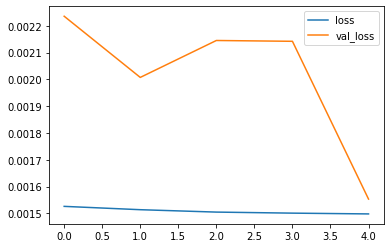

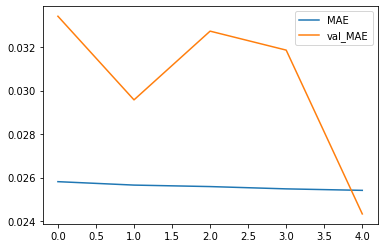

In [41]:
import matplotlib.pyplot as plt
history.history
plt.plot(history.history["loss"],label = "loss")
plt.plot(history.history["val_loss"],label = "val_loss")
plt.legend()
plt.show()
plt.close()


history.history
plt.plot(history.history["mean_absolute_error"],label = "MAE")
plt.plot(history.history["val_mean_absolute_error"],label = "val_MAE")
plt.legend()
plt.show()
plt.close()

In [42]:
# seq_X_test,seq_y_test = split_sequences(X_test,y_test, n_steps)
# fc_in_test = X_test_fc[n_steps:,:,:,:]

# y_pred = mdl.predict((fc_in_test,seq_X_test,seq_X_test,seq_X_test))
# y_pred_back = scaler_t.inverse_transform(y_pred)
# y_test_back = pd.DataFrame(seq_y_test,columns=target_vars+["Date"])
# y_test_back.loc[:,target_vars] = scaler_t.inverse_transform(y_test_back.loc[:,target_vars])

# list_names = ["Load","Wind Offshore", "Wind Onshore", "Solar"]

# for i in range(len(y_pred_back[0])):
#     print("=================================")
#     print(f"{list_names[i]}")
#     get_model_metrics(y_test_back.iloc[:,[-1,i]],y_pred_back[:,i])
#     print("=================================")

In [43]:
seq_X_test,seq_y_test = split_sequences(X_test,y_test, n_steps)
fc_in_test = X_test_fc[n_steps:,:,:,:]

y_pred = mdl.predict((fc_in_test,seq_X_test,seq_X_test,seq_X_test))
# y_pred = mdl.predict((seq_X_test,seq_X_test,seq_X_test))
y_pred_back = scaler_t.inverse_transform(y_pred)
y_test_back = pd.DataFrame(seq_y_test,columns=target_vars+["Date"])
y_test_back.loc[:,target_vars] = scaler_t.inverse_transform(y_test_back.loc[:,target_vars])

list_names = ["Load","Wind Offshore", "Wind Onshore", "Solar"]

for i in range(len(list_names)):
    print("=================================")
    print(f"{list_names[i]}")
    get_model_metrics(y_test_back.iloc[:,[-1,i]],y_pred_back[:,i])
    print("=================================")

Load
----------------------------------------------
The absolute error (total actual minus  forecast) in MW is: 2460497.88
The overall mean absolute error of the model in MW is: 284.9117502315887
The overall mean squared error of the model is: 149493.96283592234
The overall mean absolute scaled error of the model in MW is: 0.5388463835431868
----------------------------------------------
Wind Offshore
----------------------------------------------
The absolute error (total actual minus  forecast) in MW is: 651808.71
The overall mean absolute error of the model in MW is: 75.47576523509593
The overall mean squared error of the model is: 14619.037140601673
The overall mean absolute scaled error of the model in MW is: 0.8713165802562431
----------------------------------------------
Wind Onshore
----------------------------------------------
The absolute error (total actual minus  forecast) in MW is: 1245765.67
The overall mean absolute error of the model in MW is: 144.2526248942486
The ov